# Introduction
TBS

## ETL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

df = pd.read_csv('poland_daily.csv', sep=';')
df['date'] = pd.to_datetime(df['date'])
df['day'] = range(1, len(df) + 1)
df.head()

,date,infected,day
0,2020-04-03,1,1
1,2020-05-03,0,2
2,2020-06-03,4,3
3,2020-07-03,1,4
4,2020-08-03,5,5


## Define prediction function 

In [2]:
df['SMA_2'] = df.iloc[:,1].rolling(window=2).mean()
df['SMA_3'] = df.iloc[:,1].rolling(window=3).mean()
df['SMA_4'] = df.iloc[:,1].rolling(window=4).mean()
df['SMA_5'] = df.iloc[:,1].rolling(window=5).mean()
df['SMA_6'] = df.iloc[:,1].rolling(window=6).mean()
df['SMA_7'] = df.iloc[:,1].rolling(window=7).mean()

df['SMA_9'] = df.iloc[:,1].rolling(window=9).mean()
df['SMA_10'] = df.iloc[:,1].rolling(window=10).mean()
df['SMA_11'] = df.iloc[:,1].rolling(window=11).mean()
df['SMA_12'] = df.iloc[:,1].rolling(window=12).mean()
df['SMA_13'] = df.iloc[:,1].rolling(window=13).mean()

df['SMA_15'] = df.iloc[:,1].rolling(window=15).mean()
df['SMA_17'] = df.iloc[:,1].rolling(window=17).mean()
df['SMA_19'] = df.iloc[:,1].rolling(window=19).mean()
df['SMA_21'] = df.iloc[:,1].rolling(window=21).mean()
df['SMA_23'] = df.iloc[:,1].rolling(window=23).mean()

df['SMA_25'] = df.iloc[:,1].rolling(window=25).mean()
df['SMA_27'] = df.iloc[:,1].rolling(window=27).mean()
df['SMA_29'] = df.iloc[:,1].rolling(window=29).mean()
df['SMA_31'] = df.iloc[:,1].rolling(window=31).mean()
df['SMA_33'] = df.iloc[:,1].rolling(window=33).mean()

df['SMA_35'] = df.iloc[:,1].rolling(window=35).mean()
df['SMA_37'] = df.iloc[:,1].rolling(window=37).mean()
df['SMA_40'] = df.iloc[:,1].rolling(window=40).mean()
df['SMA_43'] = df.iloc[:,1].rolling(window=43).mean()

## Plot fitted function

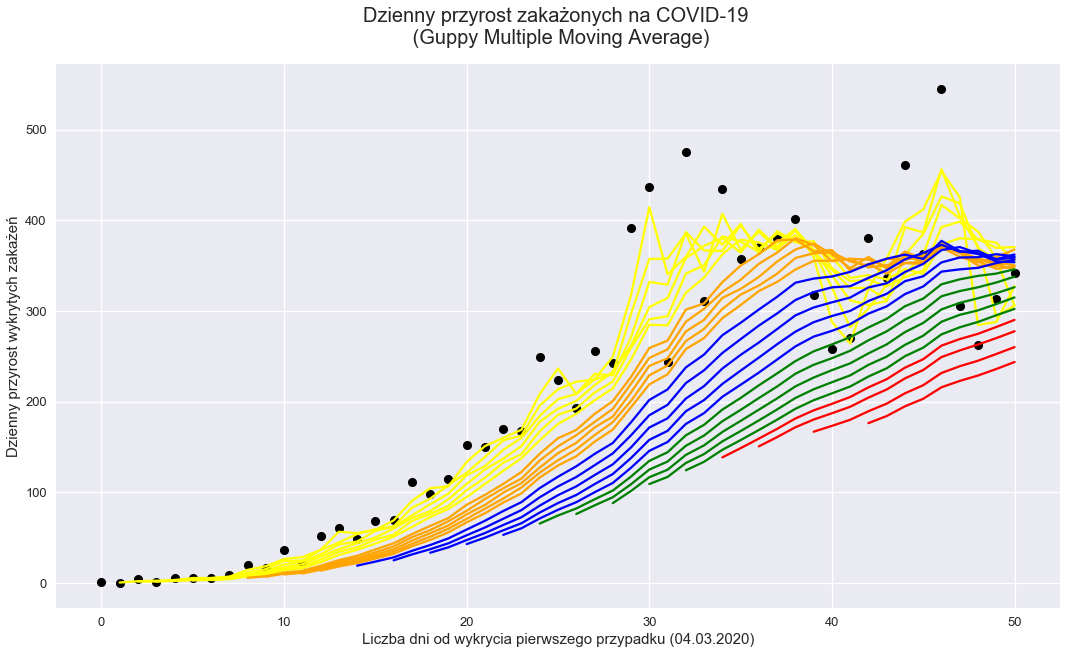

In [3]:
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

plt.figure(figsize=[18,10])
plt.grid(True)
plt.title('Dzienny przyrost zakażonych na COVID-19 \n (Guppy Multiple Moving Average)', fontsize=20, pad=20)
plt.xlabel('Liczba dni od wykrycia pierwszego przypadku (04.03.2020)', fontsize=15)
plt.ylabel('Dzienny przyrost wykrytych zakażeń', fontsize=15)

plt.plot(df['infected'], 'ko',label='Dzienny przyrost')

plt.plot(df['SMA_2'],'yellow')
plt.plot(df['SMA_3'],'yellow')
plt.plot(df['SMA_4'],'yellow')
plt.plot(df['SMA_5'],'yellow')
plt.plot(df['SMA_6'],'yellow')
plt.plot(df['SMA_7'],'yellow')

plt.plot(df['SMA_9'],'orange')
plt.plot(df['SMA_10'],'orange')
plt.plot(df['SMA_11'],'orange')
plt.plot(df['SMA_12'],'orange')
plt.plot(df['SMA_13'],'orange')

plt.plot(df['SMA_15'],'blue')
plt.plot(df['SMA_17'],'blue')
plt.plot(df['SMA_19'],'blue')
plt.plot(df['SMA_21'],'blue')
plt.plot(df['SMA_23'],'blue')

plt.plot(df['SMA_25'],'green')
plt.plot(df['SMA_27'],'green')
plt.plot(df['SMA_29'],'green')
plt.plot(df['SMA_31'],'green')
plt.plot(df['SMA_33'],'green')

plt.plot(df['SMA_35'],'red')
plt.plot(df['SMA_37'],'red')
plt.plot(df['SMA_40'],'red')
plt.plot(df['SMA_43'],'red')

#plt.legend(loc=2, prop={'size': 10})